# Data Collection

### Importing necessary libraries

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from workalendar.usa import UnitedStates

### Getting Short Range Data 

Tickers we should use:

The 6 companies we have selected:
- BRK-A: class A stock for BRK, the investing firm
- BRK-B: class B
- ORCL: oracle
- META: meta
- KO: coca-cola
- IBM: IBM
- TSLA: Tesla

Over all market prices:
-  ^GSPC: S & P 500, indicates the overall market in america. For coca-cola, BRK, and IBM.
-  ^IXIC: NASDAQ, geared towards tech companies. For META, TESLA
-  Note: Oracle (ORCL) is not NASDAQ-listed.

Sectors:

- XLF: Financials Select Sector SPDR Fund (For Berkshire Hathaway)
- XLC: Communication Services Select Sector SPDR Fund (For Meta)
- XLY: Consumer Discretionary Select Sector SPDR Fund (For Tesla)
- XLK: Technology Select Sector SPDR Fund (For IBM and Oracle)
- XLP: Consumer Staples Select Sector SPDR Fund (For Coca-Cola)

In [69]:
# creating a function to make the data collection much more easier
def get_short_data(tickers):
    """
    Fetches short-range stock data for the specified tickers.

    Parameters:
    ----------
    tickers : list or str
        A list of ticker symbols or a single ticker symbol.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing the short-range stock data for the tickers.
    """
    short_data = yf.download(
        tickers = tickers,
        period = "1mo",
        interval= "2m"
    )
    return short_data


In [70]:
# getting the data for all stocks with their sectors
BRK_A_short_data = get_short_data(["BRK-A", "XLF", "^GSPC"])
BRK_B_short_data = get_short_data(["BRK-B", "XLF", "^GSPC"])
ORACLE_short_data = get_short_data(["ORCL", "XLK", "^GSPC"])
META_short_data = get_short_data(["META", "XLK", "^IXIC"])
COCA_short_data = get_short_data(["KO", "XLP", "^GSPC"])
IBM_short_data = get_short_data(["IBM", "^GSPC", "XLK"])
TESLA_short_data = get_short_data(["TSLA", "XLY", "^IXIC"])

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


# Data Cleaning

### Data cleaning functions

In [76]:
# creating functions to make data cleaning easier
def general_description(data):
    """
    Generates and prints general descriptive statistics and information for data cleaning purposes.

    This function provides essential details about the DataFrame, such as head of the DataFrame, missing values,
    summary statistics, number of duplicates (if any), number of columns with erroneous negative values (if any) and skewness measure, to aid in data cleaning and preprocessing steps.

    Parameters
    ----------
    data : pandas DataFrame
        DataFrame that will be analyzed for general description. 

    Returns
    -------
    None
        This function prints various statistics and information.
    """
    print("Head of the data:\n\t", data.head())
    
    print("\n\nInformation on data types:\n\t")
    print(data.info())

    print("\n\nData shape:\n\t", data.shape)
    
    # getting the first level columns
    columns = {column[0] for column in data.columns}

    # iterating over the first level of columns so that the description is visible for all data
    for column in columns:
        print(f"\n\nDescription of {column} column:\n\t", data.describe()[[column]])
    
    # looking at the number of missing values for each column combination
    for column in columns:
        print(f"\n\nMissing values count on {column} column:\n\t", data[[column]].isna().sum())
    
    number_of_duplicates = data.duplicated().sum()
    print("\n\nNumber of duplicates:\n\t", number_of_duplicates)

    # calculating skewness and seeing how many rows are highly skewed
    number_skewed_columns = (np.abs(data.skew()) > 1).sum()
    print("\n\nNumber of skewed columns:\n\t", number_skewed_columns)

    # checking to see if there are any any unrealistic negative values
    number_of_negatives = ((data < 0).sum() != 0).sum()
    print("\n\nNumber of columns with negative values:\n\t", number_of_negatives)

def boxplot(data):
    """
    Generates and displays box plots for a DataFrame with a two-level column index.

    This function creates box plots for each of the columns in the input DataFrame, assuming that the DataFrame 
    has a multi-level (two-level) column index. It is useful for identifying outliers within each subgroup of 
    the multi-level column structure.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame with a two-level column index. Each column in the DataFrame will be visualized 
        as a separate box plot.

    Returns
    -------
    None
        This function generates and displays box plots for the data but does not return any values.
    """

    scaler = MinMaxScaler(feature_range=(0, 1))
    columns = {column[0] for column in data.columns}

    # initiating a separate plot for each of the first level columns
    for column in columns:
        # scaling data for clearer visualization
        scaled_data_numpy = scaler.fit_transform(data[column])
        scaled_data = pd.DataFrame(scaled_data_numpy, columns=scaler.get_feature_names_out())
        sns.boxplot(data=scaled_data,
                    palette="inferno")
        plt.title(column)
        plt.xticks(rotation=45)
        plt.show()

def get_columns_outliers(data):
    """
    Identifies and returns the column names that contain outliers in the input DataFrame.

    This function detects columns that have outliers based on inter-quartile range (IQR). 
    It returns a list of columns where outliers are detected.

    Parameters
    ----------
    data : pandas DataFrame
        The input DataFrame containing the data to be analyzed for outliers.

    Returns
    -------
    outlier_columns : list
        A list of column names (or multi-level column combinations if the DataFrame has a multi-level column index)
        that contain outliers.

    Notes
    -----
    The function assumes that outliers are defined as values beyond a certain threshold (1.5*IQR).
    """

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)

    # seeing if a column has outliers or not
    # we only want to winsorize columns with outliers
    outlier_data = ((data < lower) | (data > upper)).sum() != 0
    
    # getting a list of columns with outliers in them
    outlier_columns = outlier_data[outlier_data==True].index
    
    return outlier_columns
    


### BRK-A and BRK-B

#### BRK-A

In [143]:
general_description(BRK_A_short_data)

Head of the data:
	 Price                          Close                               High  \
Ticker                         BRK-A        XLF        ^GSPC      BRK-A   
Datetime                                                                  
2024-12-04 14:30:00+00:00  704395.00  50.369999  6068.870117  707280.00   
2024-12-04 14:32:00+00:00  704145.50  50.349998  6071.500000  705780.00   
2024-12-04 14:34:00+00:00  704100.00  50.365002  6069.899902  704541.75   
2024-12-04 14:36:00+00:00  705245.00  50.325001  6066.439941  705245.00   
2024-12-04 14:38:00+00:00  704622.25  50.339901  6066.120117  704933.25   

Price                                                     Low             \
Ticker                           XLF        ^GSPC       BRK-A        XLF   
Datetime                                                                   
2024-12-04 14:30:00+00:00  50.439999  6070.350098  703250.000  50.320000   
2024-12-04 14:32:00+00:00  50.439999  6072.080078  703437.000  50.340599   

In [144]:
# using forward fill to impute null values
BRK_A_short_data.ffill(inplace=True)

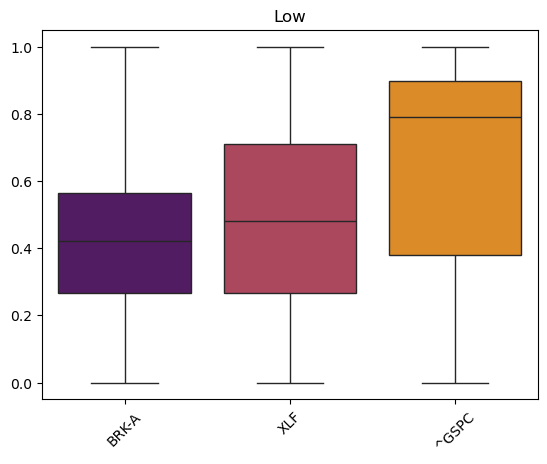

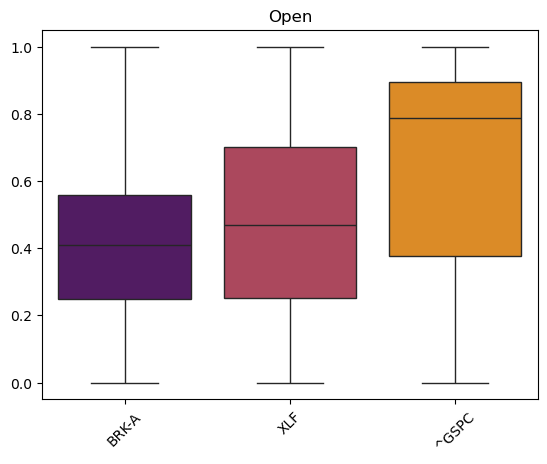

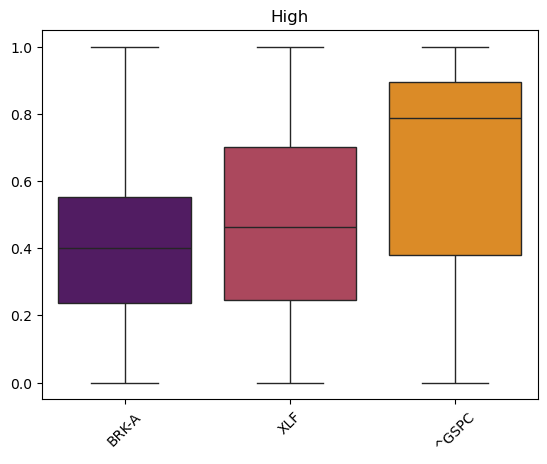

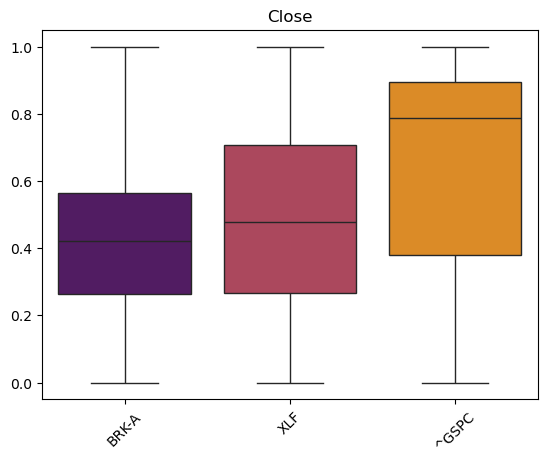

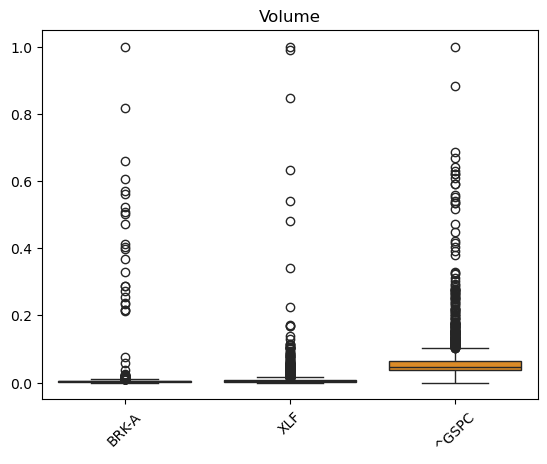

In [149]:
# seeing boxplot to visualize outliers
boxplot(BRK_A_short_data)

In [150]:
# seeing the columns with outliers
BRK_A_outlier_columns = get_columns_outliers(BRK_A_short_data)
print(BRK_A_outlier_columns)

MultiIndex([('Volume', 'BRK-A'),
            ('Volume',   'XLF'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [151]:
# using Winsorization to deal with outliers
for column in BRK_A_outlier_columns:
        q_lower = 0
        if column[1] == "BRK-A":
                q_upper = 0.96
        elif column[1] == "^GSPC":
                q_upper = 0.94
        else:
                q_upper = 0.90
        lower = BRK_A_short_data[column].quantile(q_lower)
        upper = BRK_A_short_data[column].quantile(q_upper)
        BRK_A_short_data[column] = BRK_A_short_data[column].clip(lower=lower, upper=upper)

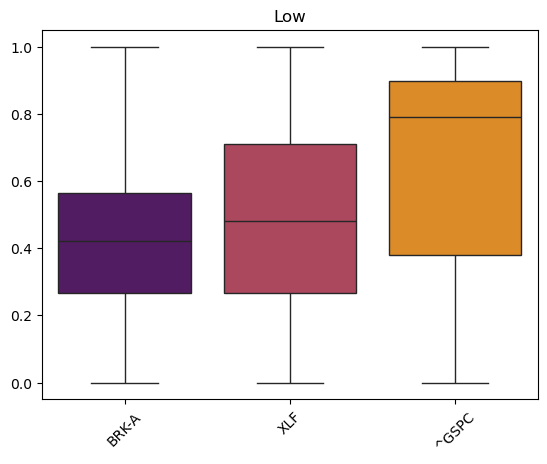

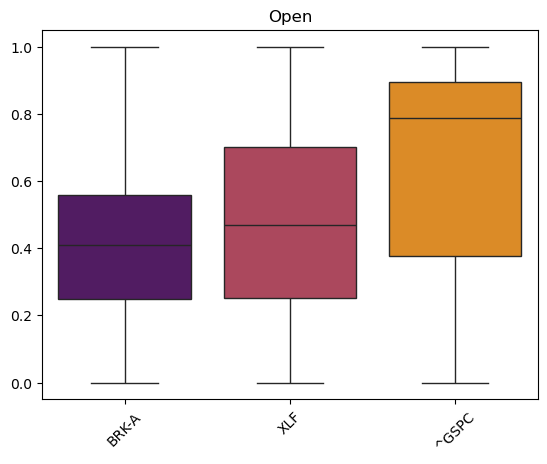

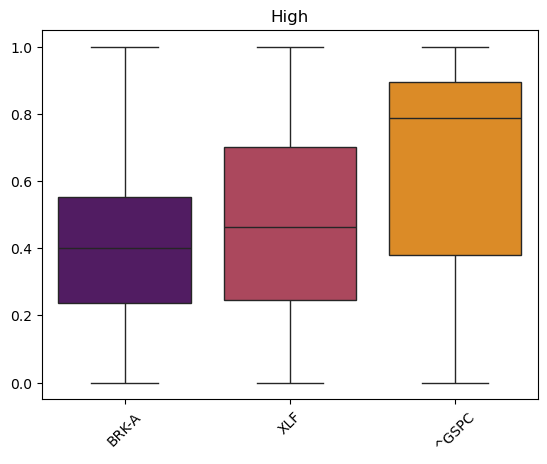

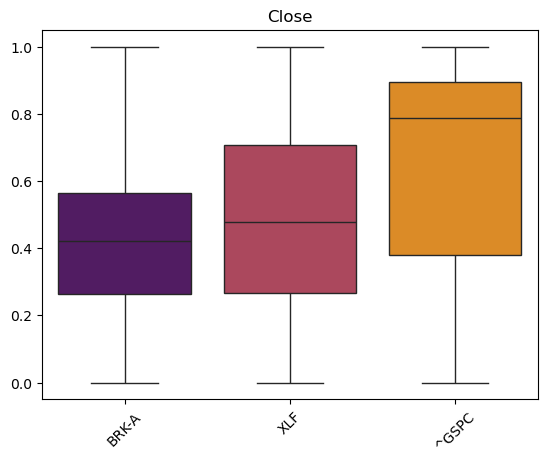

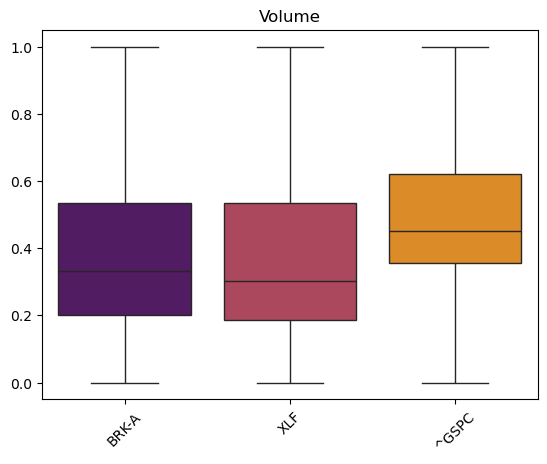

In [152]:
boxplot(BRK_A_short_data)

#### BRK-B

In [157]:
general_description(BRK_B_short_data)

Head of the data:
	 Price                           Close                                High  \
Ticker                          BRK-B        XLF        ^GSPC       BRK-B   
Datetime                                                                    
2024-12-04 14:30:00+00:00  469.785004  50.369999  6068.870117  471.339996   
2024-12-04 14:32:00+00:00  469.353088  50.349998  6071.500000  470.562103   
2024-12-04 14:34:00+00:00  469.429993  50.365002  6069.899902  469.707001   
2024-12-04 14:36:00+00:00  470.100006  50.325001  6066.439941  470.260010   
2024-12-04 14:38:00+00:00  469.783997  50.339901  6066.120117  470.029999   

Price                                                     Low             \
Ticker                           XLF        ^GSPC       BRK-B        XLF   
Datetime                                                                   
2024-12-04 14:30:00+00:00  50.439999  6070.350098  468.619995  50.320000   
2024-12-04 14:32:00+00:00  50.439999  6072.080078  469.0000

In [158]:
BRK_B_short_data.ffill(inplace=True)

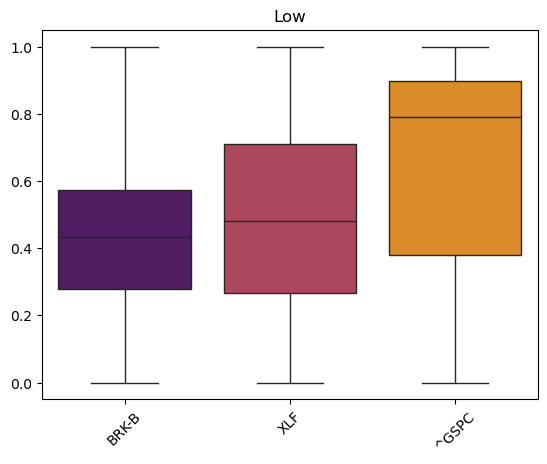

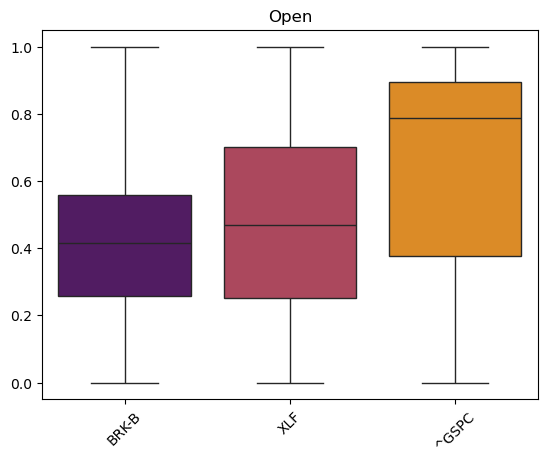

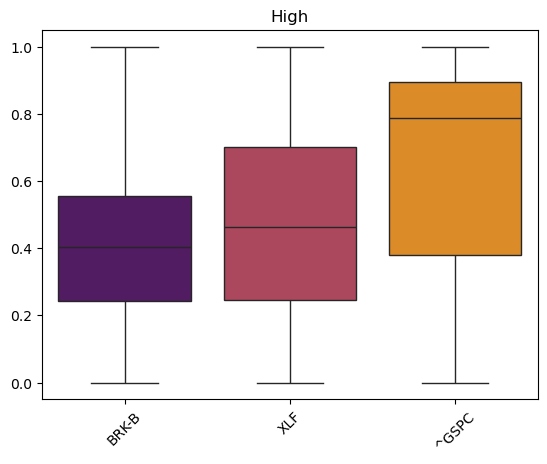

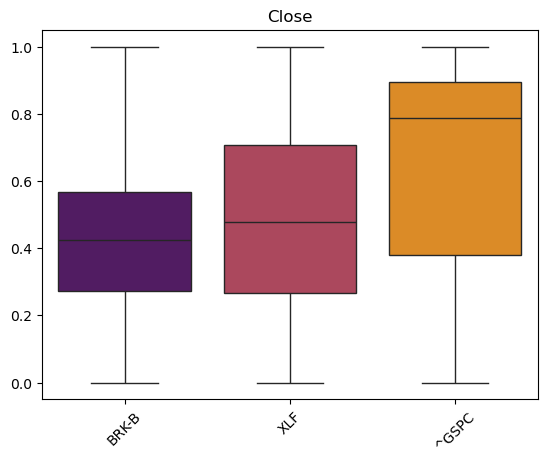

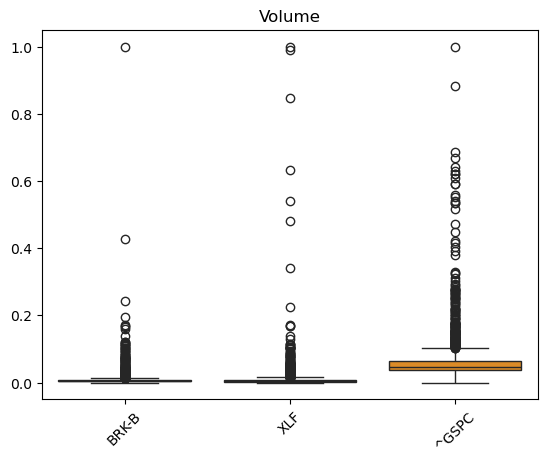

In [159]:
boxplot(BRK_B_short_data)

In [160]:
BRK_B_outlier_columns = get_columns_outliers(BRK_B_short_data)
print(BRK_A_outlier_columns)

MultiIndex([('Volume', 'BRK-A'),
            ('Volume',   'XLF'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [183]:
# using Winsorization to deal with outliers
for column in BRK_B_outlier_columns:
        q_lower = 0
        if column[1] == "BRK-B":
                q_upper = 0.92
        elif column[1] == "^GSPC":
                q_upper = 0.94
        else:
                q_upper = 0.90
        lower = BRK_B_short_data[column].quantile(q_lower)
        upper = BRK_B_short_data[column].quantile(q_upper)
        BRK_B_short_data[column] = BRK_B_short_data[column].clip(lower=lower, upper=upper)

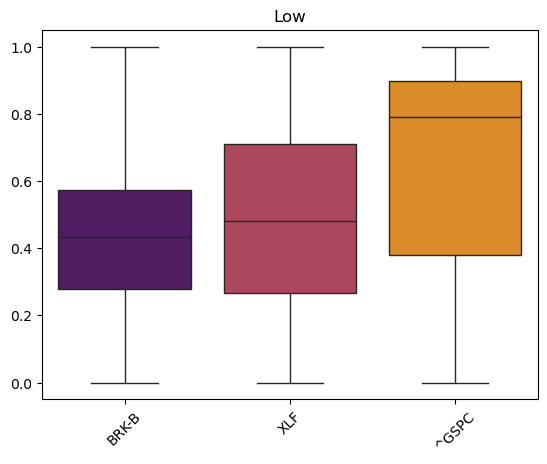

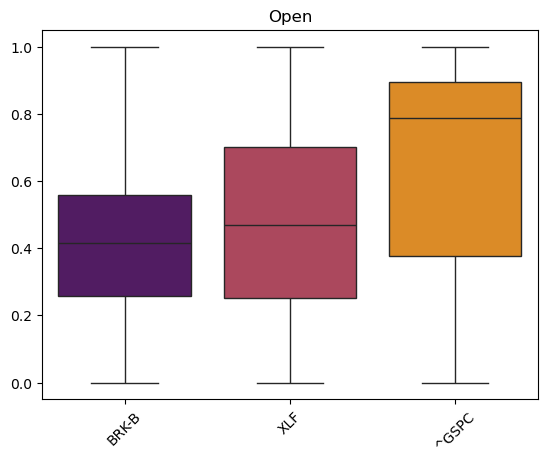

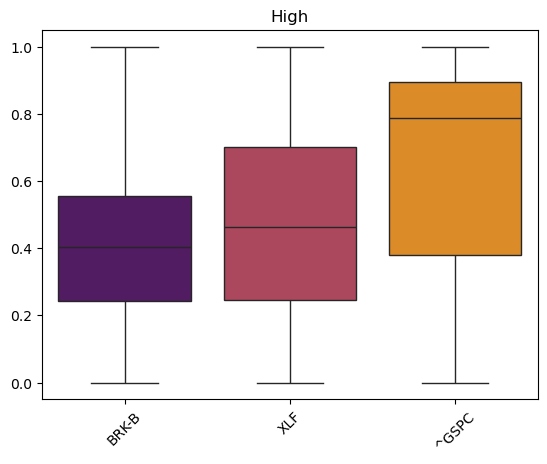

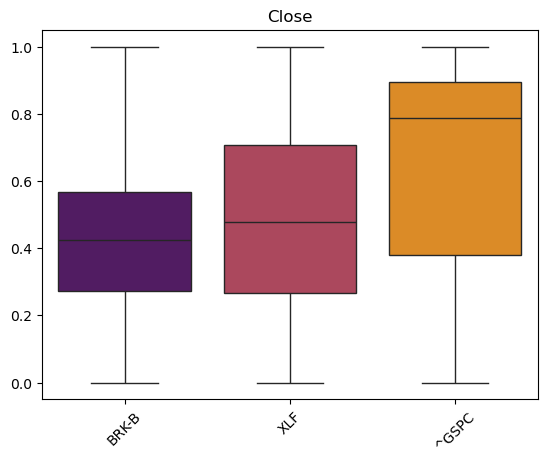

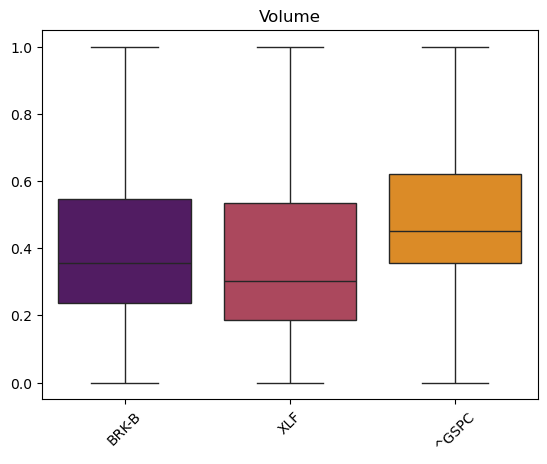

In [184]:
boxplot(BRK_B_short_data)

In [185]:
general_description(BRK_B_short_data)

Head of the data:
	 Price                           Close                                High  \
Ticker                          BRK-B        XLF        ^GSPC       BRK-B   
Datetime                                                                    
2024-12-04 14:30:00+00:00  469.785004  50.369999  6068.870117  471.339996   
2024-12-04 14:32:00+00:00  469.353088  50.349998  6071.500000  470.562103   
2024-12-04 14:34:00+00:00  469.429993  50.365002  6069.899902  469.707001   
2024-12-04 14:36:00+00:00  470.100006  50.325001  6066.439941  470.260010   
2024-12-04 14:38:00+00:00  469.783997  50.339901  6066.120117  470.029999   

Price                                                     Low             \
Ticker                           XLF        ^GSPC       BRK-B        XLF   
Datetime                                                                   
2024-12-04 14:30:00+00:00  50.439999  6070.350098  468.619995  50.320000   
2024-12-04 14:32:00+00:00  50.439999  6072.080078  469.0000

### ORACLE

In [239]:
general_description(ORACLE_short_data)

Head of the data:
	 Price                           Close                                 High  \
Ticker                           ORCL         XLK        ^GSPC        ORCL   
Datetime                                                                     
2024-12-04 14:30:00+00:00  186.479996  239.350006  6068.870117  188.020004   
2024-12-04 14:32:00+00:00  187.070007  239.630005  6071.500000  187.080002   
2024-12-04 14:34:00+00:00  187.250000  239.610001  6069.899902  187.250000   
2024-12-04 14:36:00+00:00  187.328705  239.419998  6066.439941  187.470001   
2024-12-04 14:38:00+00:00  187.089996  239.199997  6066.120117  187.559998   

Price                                                      Low              \
Ticker                            XLK        ^GSPC        ORCL         XLK   
Datetime                                                                     
2024-12-04 14:30:00+00:00  239.729996  6070.350098  185.899994  239.300003   
2024-12-04 14:32:00+00:00  239.699997  6072

In [240]:
# dealing wit missing values
ORACLE_short_data.ffill(inplace=True)

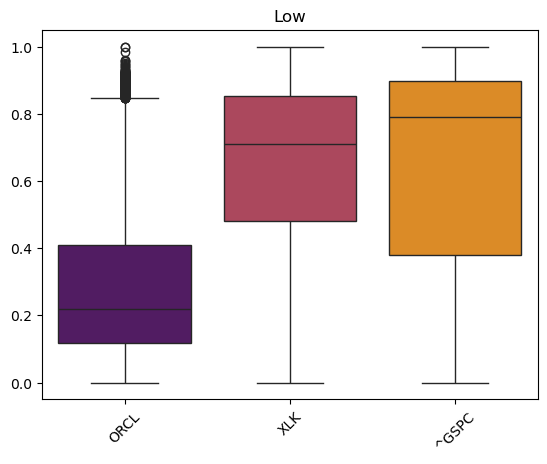

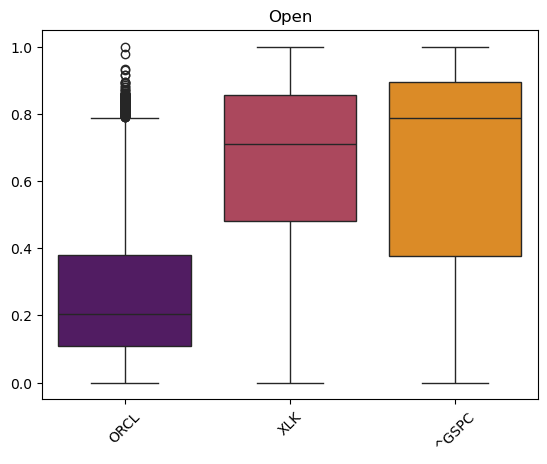

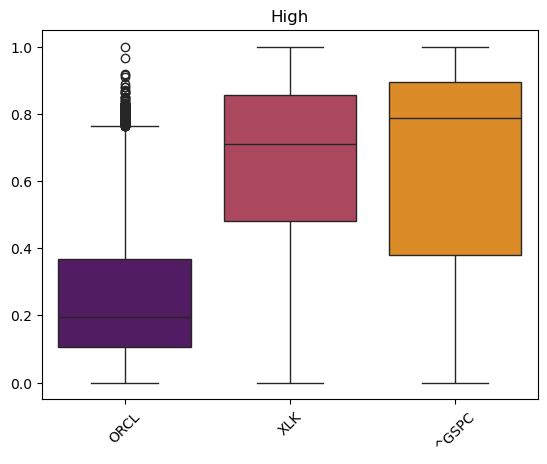

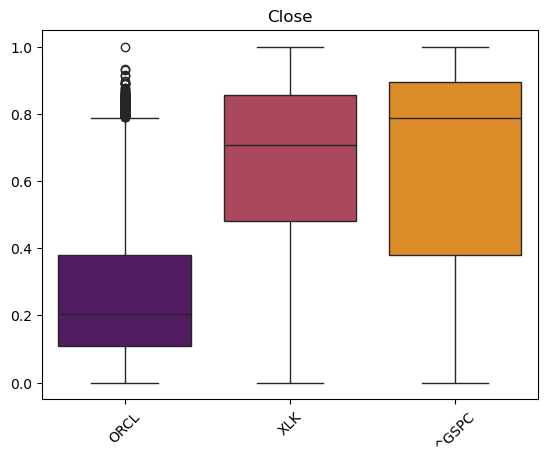

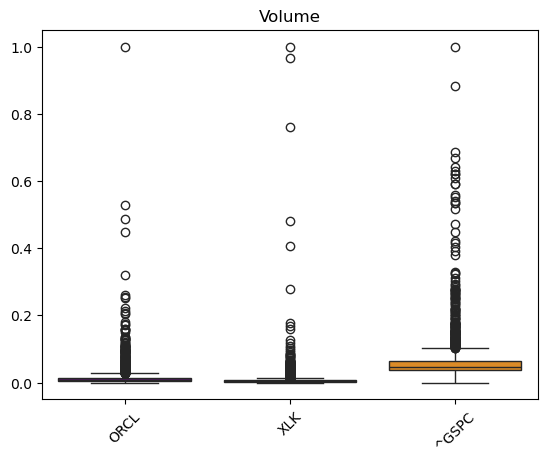

In [241]:
boxplot(ORACLE_short_data)

In [242]:
ORACLE_outlier_columns = get_columns_outliers(ORACLE_short_data)
print(ORACLE_outlier_columns)

MultiIndex([( 'Close',  'ORCL'),
            (  'High',  'ORCL'),
            (   'Low',  'ORCL'),
            (  'Open',  'ORCL'),
            ('Volume',  'ORCL'),
            ('Volume',   'XLK'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [251]:
# using Winsorization to deal with outliers
for column in ORACLE_outlier_columns:
        q_lower = 0
        if column[0] == "Volume":
                if column[1] == "ORCL":
                        q_upper = 0.91
                elif column[1] == "XLK":
                        q_upper = 0.90
                else:
                        q_upper = 0.94
        else:
                q_upper = 0.93
        lower = ORACLE_short_data[column].quantile(q_lower)
        upper = ORACLE_short_data[column].quantile(q_upper)
        x[column] = ORACLE_short_data[column].clip(lower=lower, upper=upper)

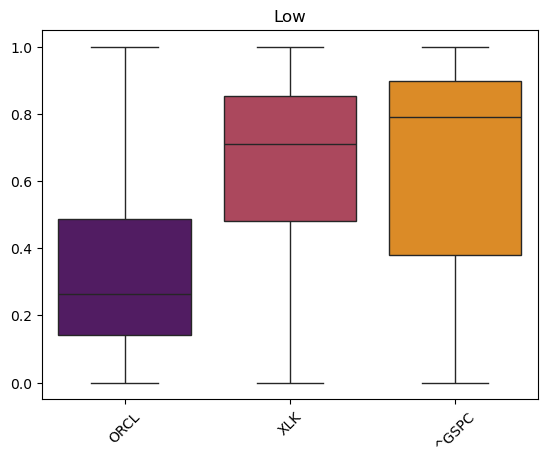

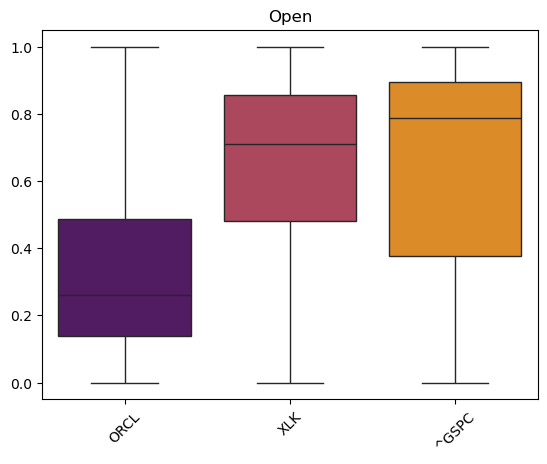

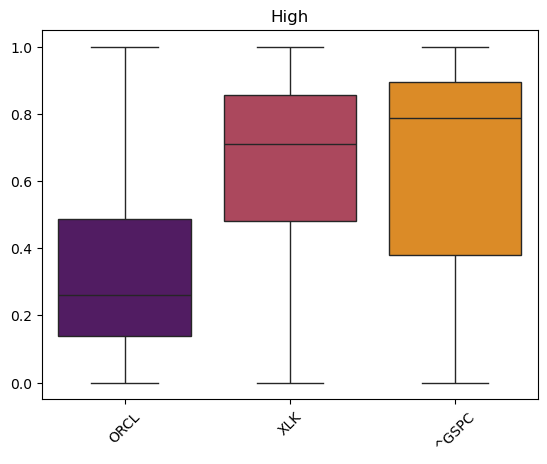

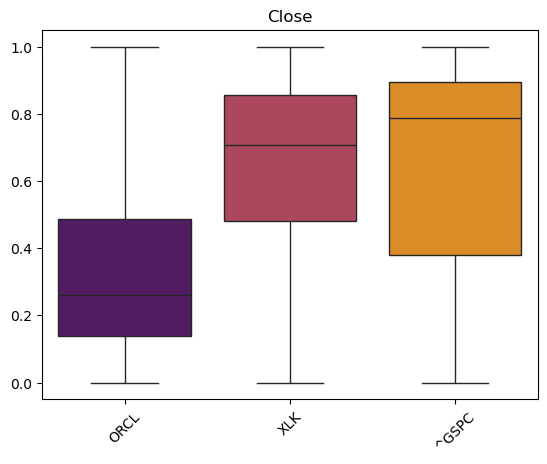

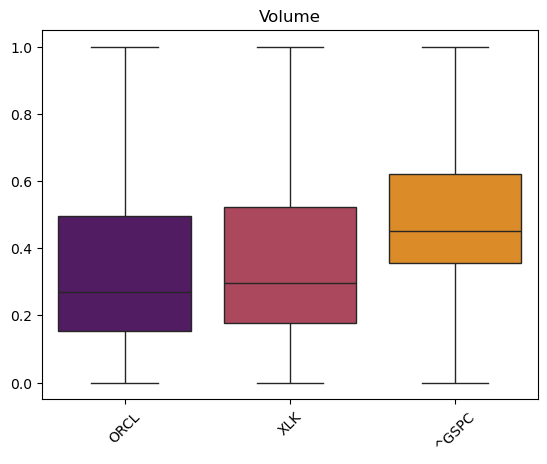

In [252]:
boxplot(ORACLE_short_data)

### META

In [253]:
general_description(META_short_data)

Head of the data:
	 Price                           Close                                  High  \
Ticker                           META         XLK         ^IXIC        META   
Datetime                                                                      
2024-12-04 14:30:00+00:00  611.614990  239.350006  19581.851562  614.710022   
2024-12-04 14:32:00+00:00  612.948975  239.630005  19615.244141  613.280029   
2024-12-04 14:34:00+00:00  614.059875  239.610001  19608.400391  614.059875   
2024-12-04 14:36:00+00:00  615.200012  239.419998  19593.730469  616.325989   
2024-12-04 14:38:00+00:00  612.390015  239.199997  19589.498047  615.999878   

Price                                                       Low              \
Ticker                            XLK         ^IXIC        META         XLK   
Datetime                                                                      
2024-12-04 14:30:00+00:00  239.729996  19607.402344  611.400024  239.300003   
2024-12-04 14:32:00+00:00  239.

In [254]:
META_short_data.ffill(inplace=True)

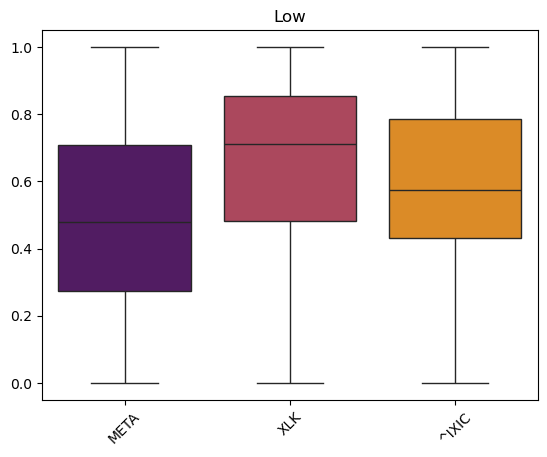

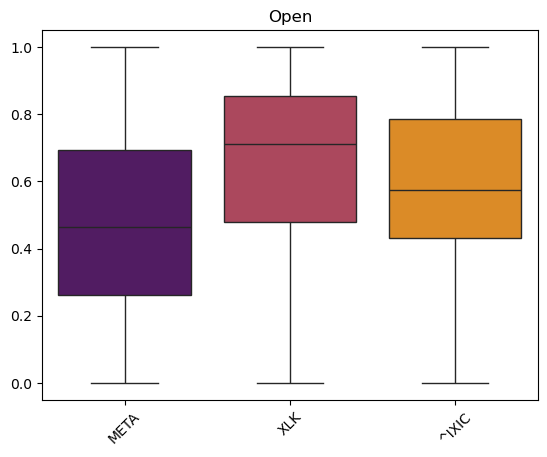

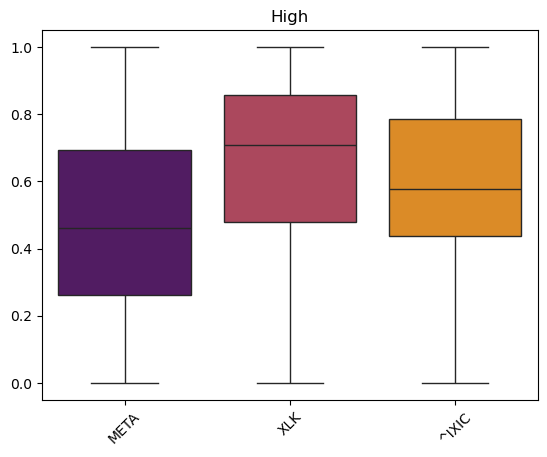

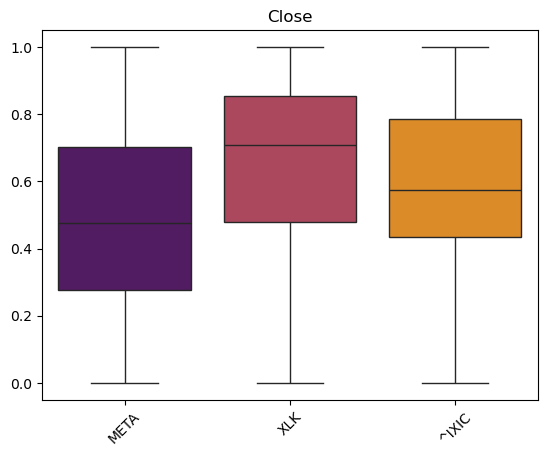

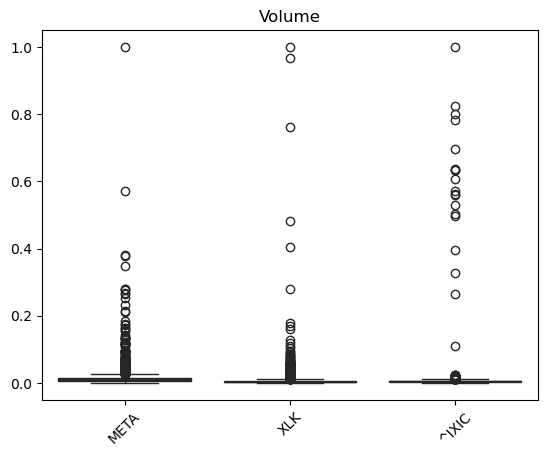

In [255]:
boxplot(META_short_data)

In [256]:
META_outlier_columns = get_columns_outliers(META_short_data)
print(META_outlier_columns)

MultiIndex([('Volume',  'META'),
            ('Volume',   'XLK'),
            ('Volume', '^IXIC')],
           names=['Price', 'Ticker'])


In [271]:
# using Winsorization to deal with outliers
for column in META_outlier_columns:
        q_lower = 0
        if column[1] == "META":
                q_upper = 0.91
        elif column[1] == "XLK":
                q_upper = 0.90
        else:
                q_upper = 0.94
        lower = META_short_data[column].quantile(q_lower)
        upper = META_short_data[column].quantile(q_upper)
        META_short_data[column] = META_short_data[column].clip(lower=lower, upper=upper)

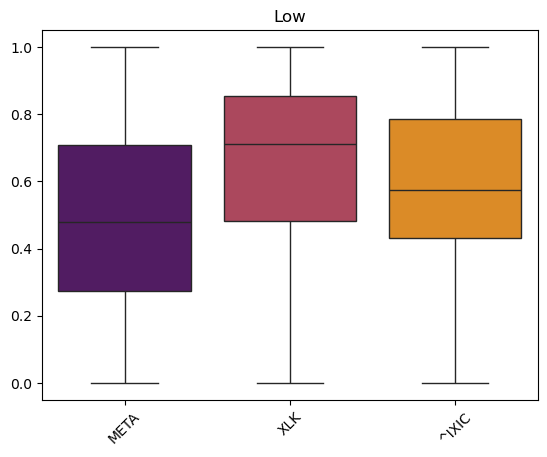

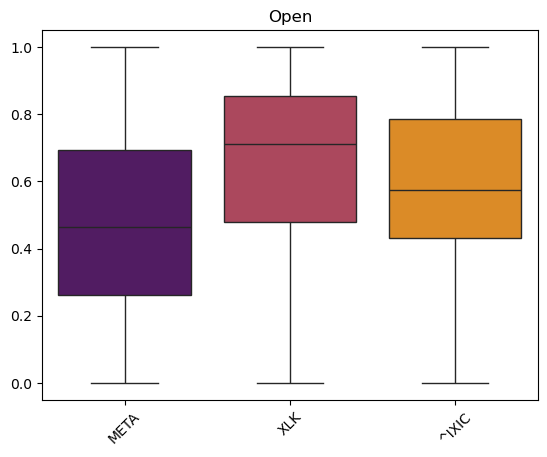

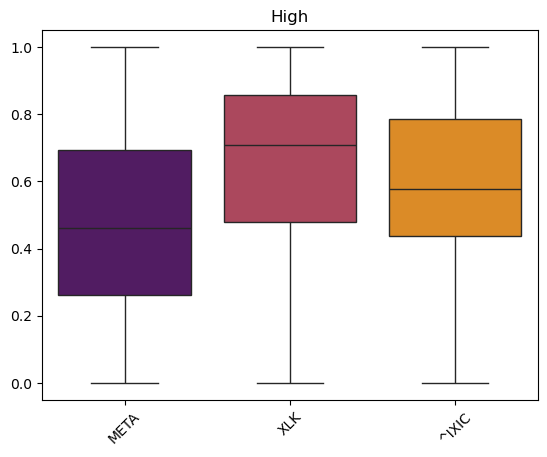

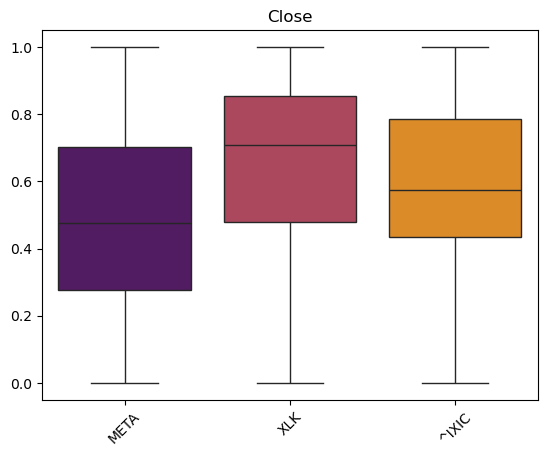

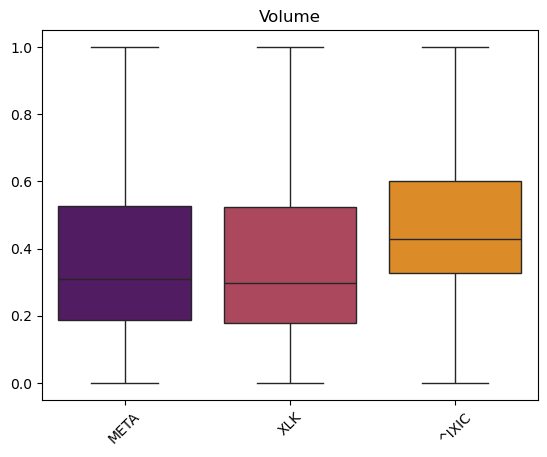

In [272]:
boxplot(META_short_data)

### COCA

In [273]:
general_description(COCA_short_data)

Head of the data:
	 Price                          Close                               High  \
Ticker                            KO        XLP        ^GSPC         KO   
Datetime                                                                  
2024-12-04 14:30:00+00:00  63.240002  82.470001  6068.870117  63.349998   
2024-12-04 14:32:00+00:00  63.049999  82.290001  6071.500000  63.299999   
2024-12-04 14:34:00+00:00  63.060001  82.309998  6069.899902  63.180000   
2024-12-04 14:36:00+00:00  63.095001  82.300003  6066.439941  63.139999   
2024-12-04 14:38:00+00:00  63.070000  82.349998  6066.120117  63.105202   

Price                                                    Low             \
Ticker                           XLP        ^GSPC         KO        XLP   
Datetime                                                                  
2024-12-04 14:30:00+00:00  82.480003  6070.350098  62.880001  82.180000   
2024-12-04 14:32:00+00:00  82.580002  6072.080078  63.049999  82.290001   
2024

In [275]:
COCA_short_data.ffill(inplace=True)

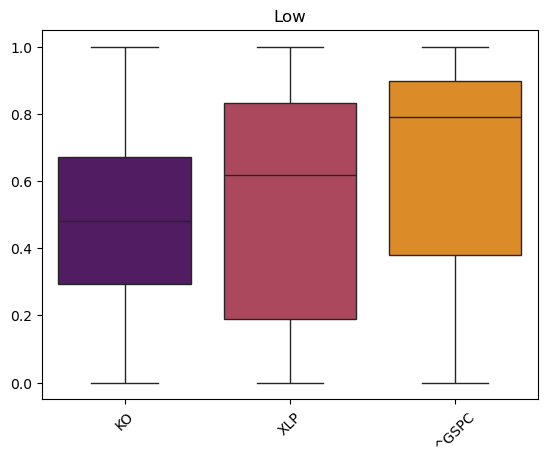

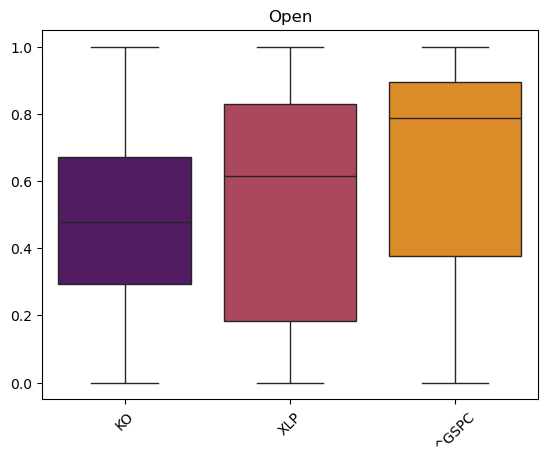

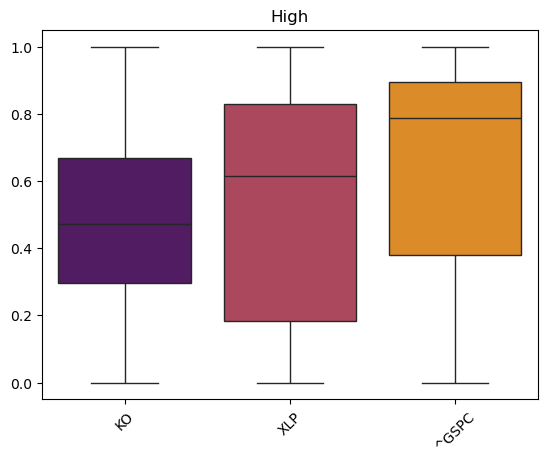

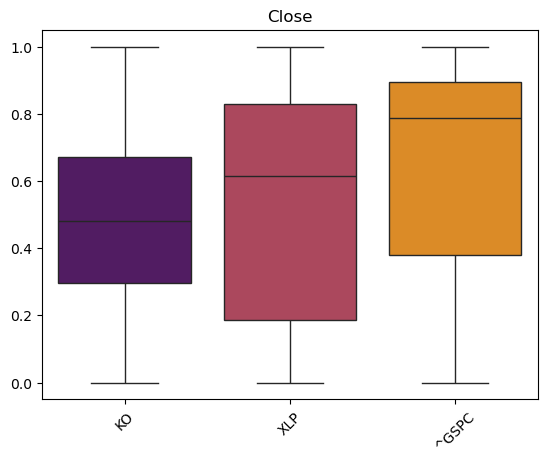

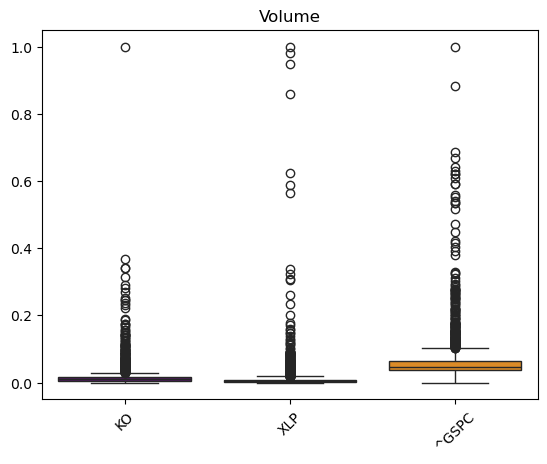

In [276]:
boxplot(COCA_short_data)

In [278]:
COCA_outlier_columns = get_columns_outliers(COCA_short_data)
print(COCA_outlier_columns)

MultiIndex([('Volume',    'KO'),
            ('Volume',   'XLP'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [285]:
# using Winsorization to deal with outliers
for column in COCA_outlier_columns:
        q_lower = 0
        if column[1] == "KO":
                q_upper = 0.92
        elif column[1] == "^GSPC":
                q_upper = 0.94
        else:
                q_upper = 0.89
        lower = COCA_short_data[column].quantile(q_lower)
        upper = COCA_short_data[column].quantile(q_upper)
        COCA_short_data[column] = COCA_short_data[column].clip(lower=lower, upper=upper)

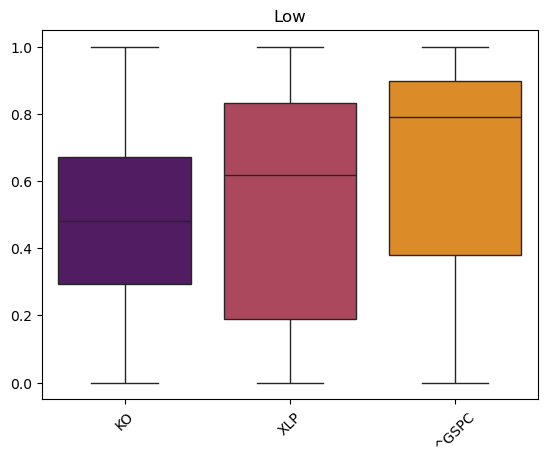

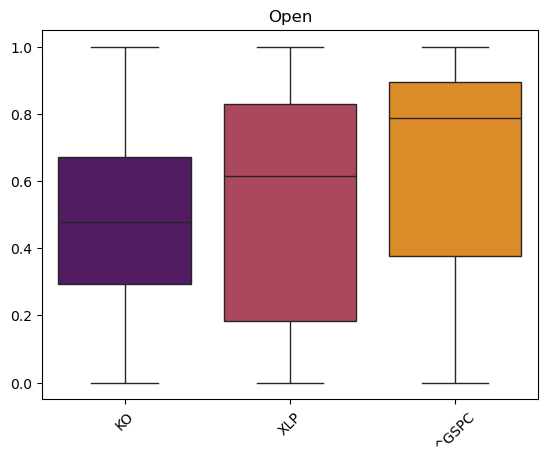

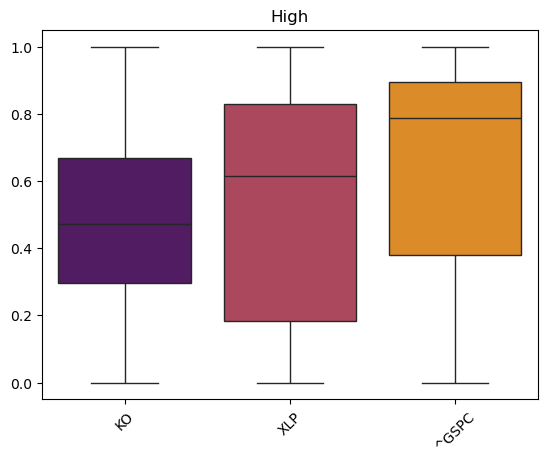

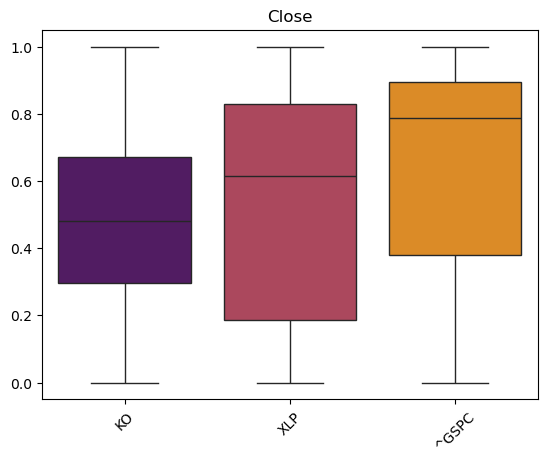

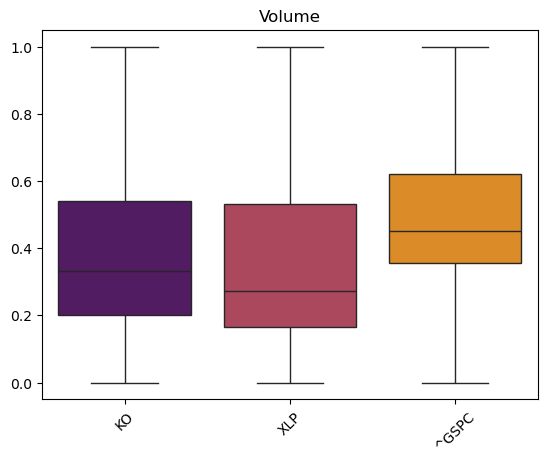

In [286]:
boxplot(COCA_short_data)

### IBM

In [287]:
general_description(IBM_short_data)

Head of the data:
	 Price                           Close                                 High  \
Ticker                            IBM         XLK        ^GSPC         IBM   
Datetime                                                                     
2024-12-04 14:30:00+00:00  229.764999  239.350006  6068.870117  230.020004   
2024-12-04 14:32:00+00:00  229.820007  239.630005  6071.500000  229.919998   
2024-12-04 14:34:00+00:00  230.285004  239.610001  6069.899902  230.570007   
2024-12-04 14:36:00+00:00  230.029999  239.419998  6066.439941  230.240005   
2024-12-04 14:38:00+00:00  230.380005  239.199997  6066.120117  230.380005   

Price                                                      Low              \
Ticker                            XLK        ^GSPC         IBM         XLK   
Datetime                                                                     
2024-12-04 14:30:00+00:00  239.729996  6070.350098  229.350006  239.300003   
2024-12-04 14:32:00+00:00  239.699997  6072

In [288]:
IBM_short_data.ffill(inplace=True)

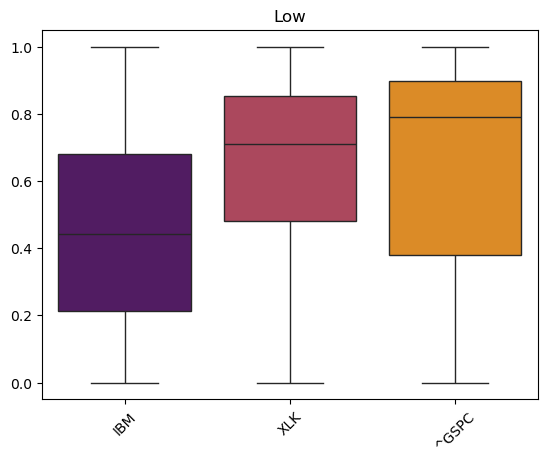

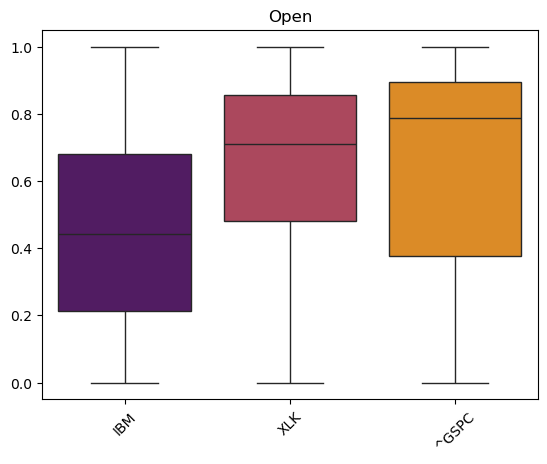

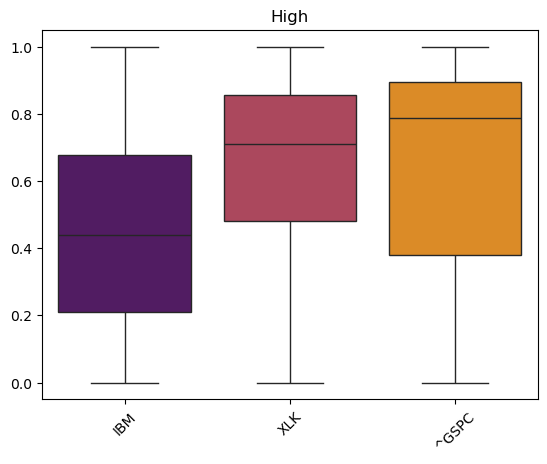

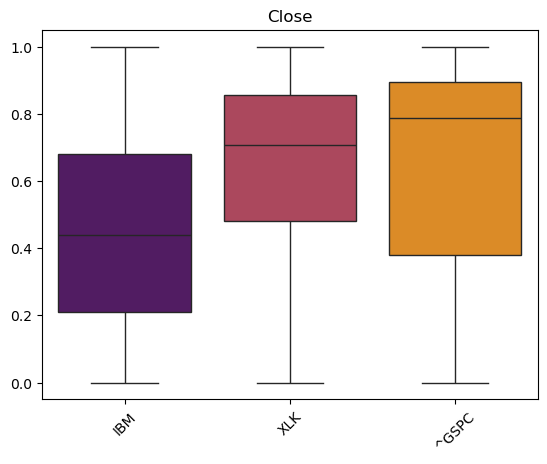

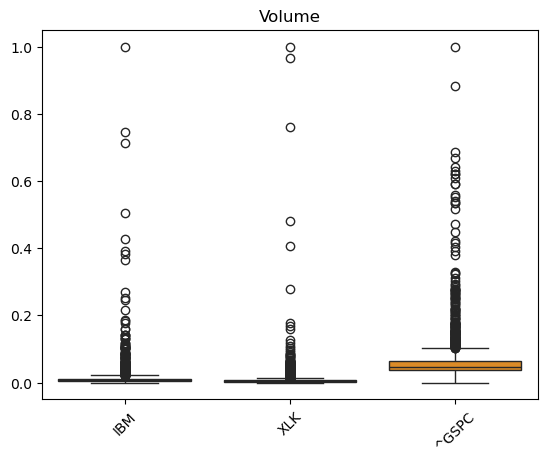

In [289]:
boxplot(IBM_short_data)

In [290]:
IBM_outlier_columns = get_columns_outliers(IBM_short_data)
print(IBM_outlier_columns)

MultiIndex([('Volume',   'IBM'),
            ('Volume',   'XLK'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


In [300]:
# using Winsorization to deal with outliers
for column in IBM_outlier_columns:
        q_lower = 0
        if column[1] == "IBM":
                q_upper = 0.91
        elif column[1] == "^GSPC":
                q_upper = 0.94
        else:
                q_upper = 0.90
        lower = IBM_short_data[column].quantile(q_lower)
        upper = IBM_short_data[column].quantile(q_upper)
        IBM_short_data[column] = IBM_short_data[column].clip(lower=lower, upper=upper)

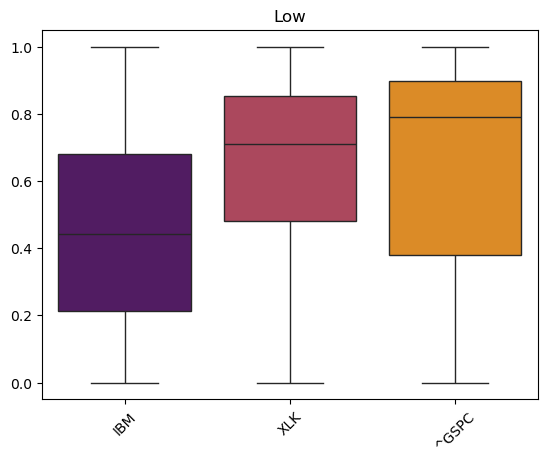

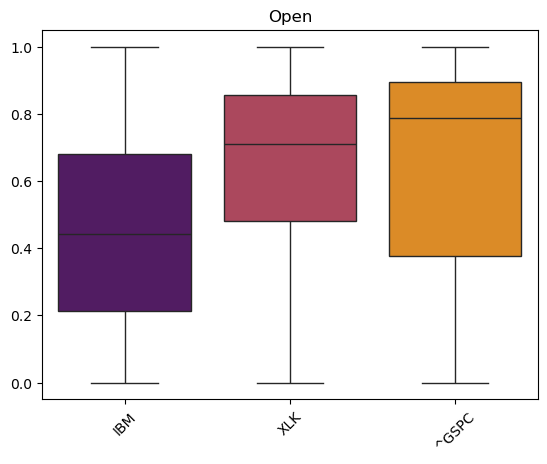

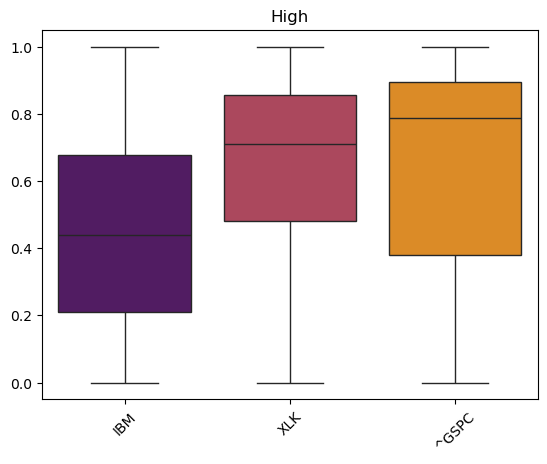

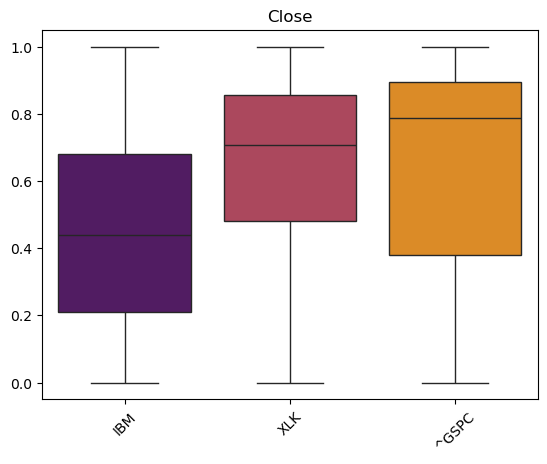

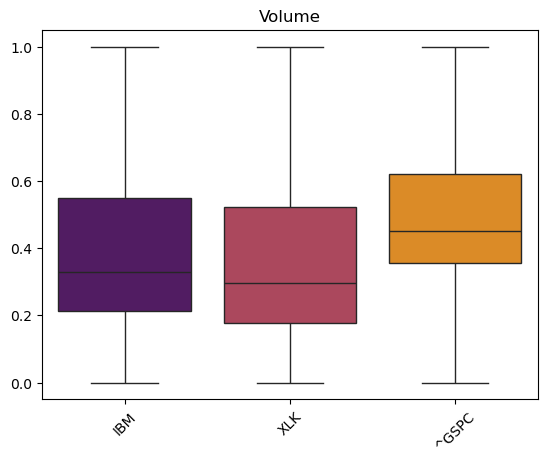

In [301]:
boxplot(IBM_short_data)

### TESLA

In [303]:
general_description(TESLA_short_data)

Head of the data:
	 Price                           Close                                  High  \
Ticker                           TSLA         XLY         ^IXIC        TSLA   
Datetime                                                                      
2024-12-04 14:30:00+00:00  350.799988  224.520004  19581.851562  353.420013   
2024-12-04 14:32:00+00:00  351.220001  224.779999  19615.244141  351.600006   
2024-12-04 14:34:00+00:00  349.364990  224.419998  19608.400391  351.489990   
2024-12-04 14:36:00+00:00  349.604095  224.460007  19593.730469  350.500000   
2024-12-04 14:38:00+00:00  349.390015  224.559998  19589.498047  350.260010   

Price                                                       Low              \
Ticker                            XLY         ^IXIC        TSLA         XLY   
Datetime                                                                      
2024-12-04 14:30:00+00:00  224.750000  19607.402344  350.519989  224.460007   
2024-12-04 14:32:00+00:00  224.

In [304]:
TESLA_short_data.ffill(inplace=True)

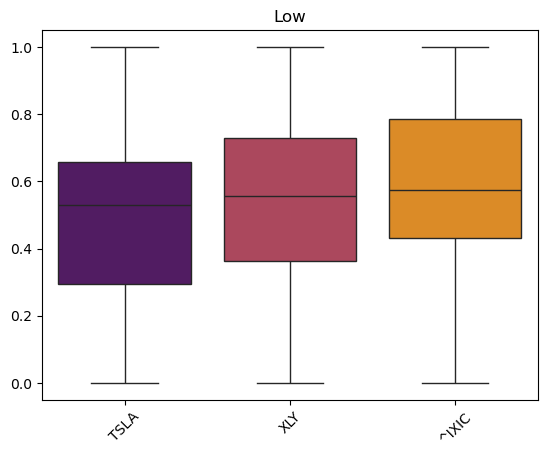

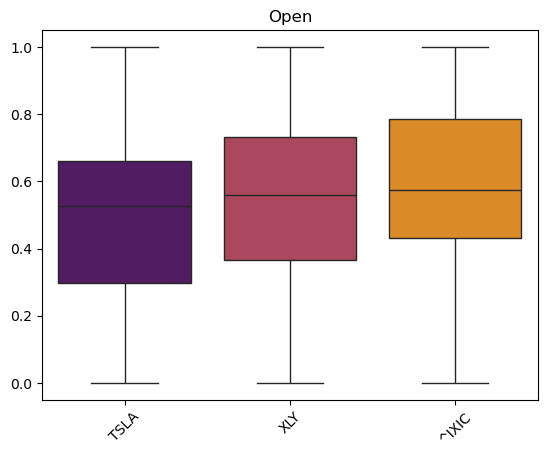

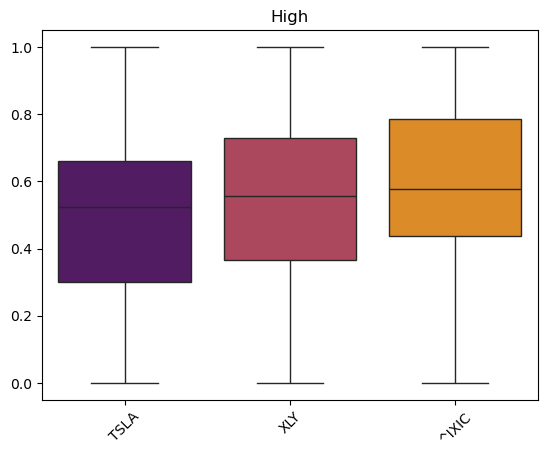

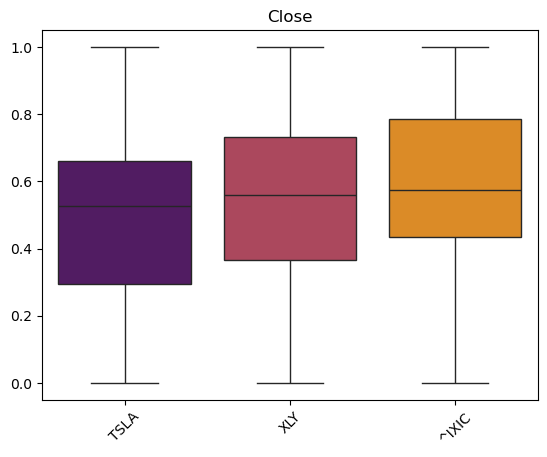

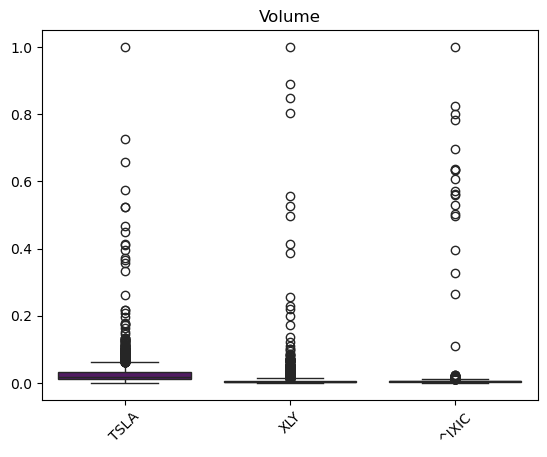

In [305]:
boxplot(TESLA_short_data)

In [307]:
TESLA_outlier_columns = get_columns_outliers(TESLA_short_data)
print(TESLA_outlier_columns)

MultiIndex([('Volume',  'TSLA'),
            ('Volume',   'XLY'),
            ('Volume', '^IXIC')],
           names=['Price', 'Ticker'])


In [316]:
# using Winsorization to deal with outliers
for column in TESLA_outlier_columns:
        q_lower = 0
        if column[1] == "TSLA":
                q_upper = 0.93
        elif column[1] == "^IXIC":
                q_upper = 0.94
        else:
                q_upper = 0.90
        lower = TESLA_short_data[column].quantile(q_lower)
        upper = TESLA_short_data[column].quantile(q_upper)
        TESLA_short_data[column] = TESLA_short_data[column].clip(lower=lower, upper=upper)

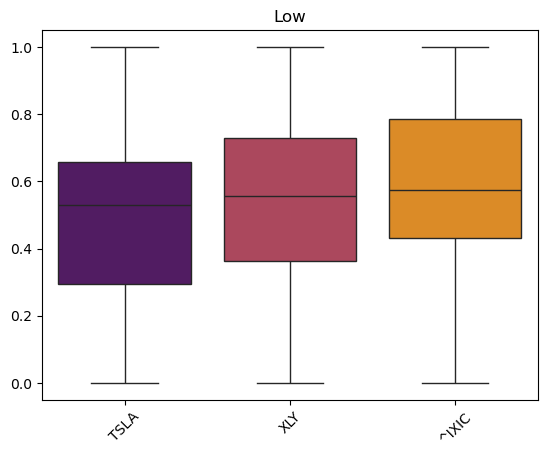

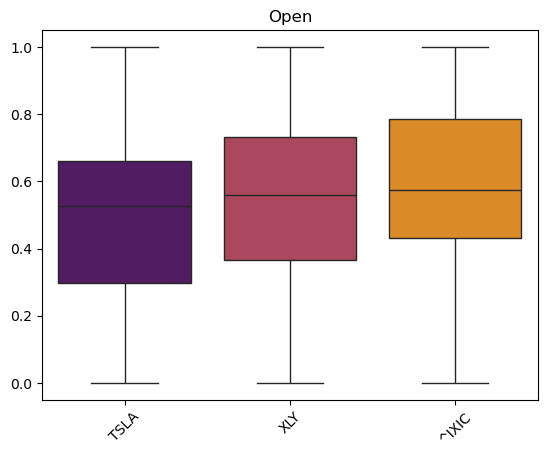

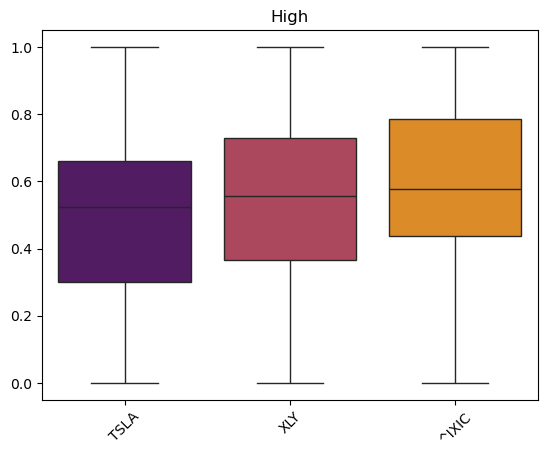

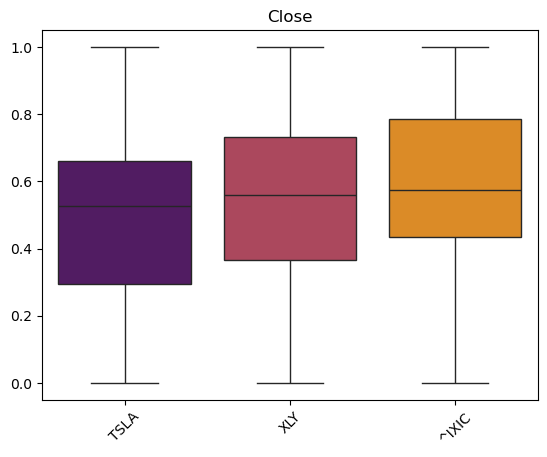

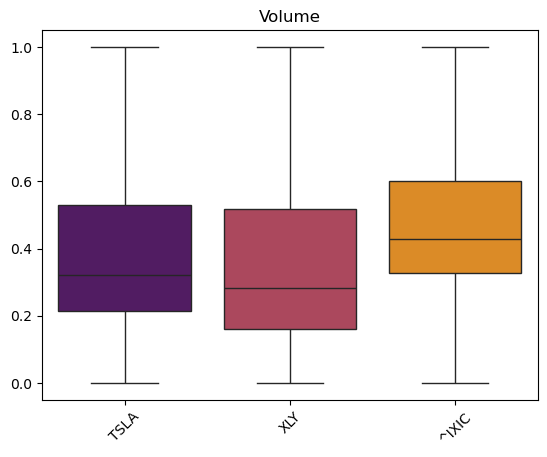

In [317]:
boxplot(TESLA_short_data)

# EDA

### Univariate EDA

##### Last week's Summary statistics

In [368]:
# getting last weeks summary statistics
def week_summary(data):
    """
    Prints summary statistics  for the past week (7 days) of a stock.

    Parameters:
    data (pandas.DataFrame): The stock data dataframe with a datetime index.
 
    Returns:
    None: The function prints the summary statistics directly.
    """
    data = pd.DataFrame(data)
    index_start = data.index.max() - pd.Timedelta("7d")
    print(data[index_start :].describe())

In [381]:
week_summary(BRK_A_short_data)

Price           Close                                    High              \
Ticker          BRK-A         XLF        ^GSPC          BRK-A         XLF   
count      781.000000  781.000000   781.000000     781.000000  781.000000   
mean    679212.886444   48.333943  5902.684435  679370.421575   48.354986   
std       2071.022568    0.158798    28.678791    2079.896950    0.156938   
min     674210.250000   47.875000  5832.290039  674726.500000   47.930000   
25%     677649.750000   48.235001  5883.009766  677880.000000   48.255001   
50%     679382.000000   48.360001  5904.520020  679549.750000   48.375000   
75%     680719.750000   48.445000  5927.910156  680827.000000   48.462101   
max     685178.000000   48.740002  5972.250000  686090.000000   48.764999   

Price                          Low                                    Open  \
Ticker        ^GSPC          BRK-A         XLF        ^GSPC          BRK-A   
count    781.000000     781.000000  781.000000   781.000000     781.00000

In [380]:
week_summary(BRK_B_short_data)

Price        Close                                 High              \
Ticker       BRK-B         XLF        ^GSPC       BRK-B         XLF   
count   781.000000  781.000000   781.000000  781.000000  781.000000   
mean    452.861574   48.333943  5902.684435  453.053182   48.354986   
std       1.398949    0.158798    28.678791    1.383720    0.156938   
min     449.339386   47.875000  5832.290039  449.940002   47.930000   
25%     451.799988   48.235001  5883.009766  452.000000   48.255001   
50%     452.980011   48.360001  5904.520020  453.165009   48.375000   
75%     453.850006   48.445000  5927.910156  454.019989   48.462101   
max     456.899994   48.740002  5972.250000  457.570007   48.764999   

Price                       Low                                 Open  \
Ticker        ^GSPC       BRK-B         XLF        ^GSPC       BRK-B   
count    781.000000  781.000000  781.000000   781.000000  781.000000   
mean    5904.882154  452.676584   48.312830  5900.509178  452.862238   
s

In [379]:
week_summary(ORACLE_short_data)

Price        Close                                 High              \
Ticker        ORCL         XLK        ^GSPC        ORCL         XLK   
count   781.000000  781.000000   781.000000  781.000000  781.000000   
mean    166.429355  233.779404  5902.684435  166.534811  233.904660   
std       0.672707    1.604387    28.678791    0.672089    1.581849   
min     164.699997  229.979996  5832.290039  164.770004  230.080002   
25%     166.075195  232.679993  5883.009766  166.164993  232.850006   
50%     166.360001  233.940002  5904.520020  166.450394  234.089996   
75%     166.779999  235.130005  5927.910156  166.886581  235.220001   
max     168.990005  237.500000  5972.250000  169.139999  237.500000   

Price                       Low                                 Open  \
Ticker        ^GSPC        ORCL         XLK        ^GSPC        ORCL   
count    781.000000  781.000000  781.000000   781.000000  781.000000   
mean    5904.882154  166.330519  233.653616  5900.509178  166.434437   
s

In [378]:
week_summary(META_short_data)

Price        Close                                  High              \
Ticker        META         XLK         ^IXIC        META         XLK   
count   781.000000  781.000000    781.000000  781.000000  781.000000   
mean    595.260378  233.779404  19438.444507  595.698246  233.904660   
std       5.695934    1.604387    132.526293    5.693941    1.581849   
min     584.619995  229.979996  19126.962891  585.179993  230.080002   
25%     590.390015  232.679993  19348.595703  590.905029  232.850006   
50%     594.909973  233.940002  19446.349609  595.169983  234.089996   
75%     599.494995  235.130005  19553.808594  599.919983  235.220001   
max     608.919983  237.500000  19724.658203  609.500000  237.500000   

Price                        Low                                  Open  \
Ticker         ^IXIC        META         XLK         ^IXIC        META   
count     781.000000  781.000000  781.000000    781.000000  781.000000   
mean    19446.630757  594.816045  233.653616  19430.38162

In [377]:
week_summary(COCA_short_data)

Price        Close                                 High              \
Ticker          KO         XLP        ^GSPC          KO         XLP   
count   781.000000  781.000000   781.000000  781.000000  781.000000   
mean     61.998266   78.464625  5902.684435   62.020636   78.487914   
std       0.172228    0.183738    28.678791    0.174587    0.185490   
min      61.625000   78.089996  5832.290039   61.660000   78.129997   
25%      61.889999   78.334999  5883.009766   61.910000   78.360001   
50%      61.990002   78.470001  5904.520020   62.009998   78.495003   
75%      62.084999   78.570000  5927.910156   62.105000   78.584999   
max      62.735001   79.309998  5972.250000   62.750000   79.320000   

Price                       Low                                 Open  \
Ticker        ^GSPC          KO         XLP        ^GSPC          KO   
count    781.000000  781.000000  781.000000   781.000000  781.000000   
mean    5904.882154   61.975546   78.442570  5900.509178   61.998791   
s

In [376]:
week_summary(IBM_short_data)

Price        Close                                 High              \
Ticker         IBM         XLK        ^GSPC         IBM         XLK   
count   781.000000  781.000000   781.000000  781.000000  781.000000   
mean    220.231506  233.779404  5902.684435  220.349729  233.904660   
std       1.434876    1.604387    28.678791    1.437032    1.581849   
min     217.809998  229.979996  5832.290039  217.889999  230.080002   
25%     219.100006  232.679993  5883.009766  219.190002  232.850006   
50%     219.849792  233.940002  5904.520020  219.949997  234.089996   
75%     221.375000  235.130005  5927.910156  221.520004  235.220001   
max     223.660004  237.500000  5972.250000  223.660004  237.500000   

Price                       Low                                 Open  \
Ticker        ^GSPC         IBM         XLK        ^GSPC         IBM   
count    781.000000  781.000000  781.000000   781.000000  781.000000   
mean    5904.882154  220.116173  233.653616  5900.509178  220.233874   
s

In [375]:
week_summary(TESLA_short_data)

Price        Close                                  High              \
Ticker        TSLA         XLY         ^IXIC        TSLA         XLY   
count   781.000000  781.000000    781.000000  781.000000  781.000000   
mean    402.819941  224.626055  19438.444507  403.485874  224.737809   
std      16.699468    2.005677    132.526293   16.654311    1.991941   
min     374.000000  220.029999  19126.962891  374.549988  220.149994   
25%     385.299988  223.270004  19348.595703  386.640015  223.389999   
50%     407.239990  225.009995  19446.349609  407.769989  225.100006   
75%     419.195007  226.089996  19553.808594  420.029999  226.179993   
max     431.705688  229.729996  19724.658203  431.899994  229.750000   

Price                        Low                                  Open  \
Ticker         ^IXIC        TSLA         XLY         ^IXIC        TSLA   
count     781.000000  781.000000  781.000000    781.000000  781.000000   
mean    19446.630757  402.145853  224.514861  19430.38162

##### Last month's summary statistics

In [389]:
# getting last month's summary statistics
# each data is already one month long

BRK_A_short_data.describe()

Price           Close                                     High               \
Ticker          BRK-A          XLF        ^GSPC          BRK-A          XLF   
count     4005.000000  4005.000000  4005.000000    4005.000000  4005.000000   
mean    687581.778152    49.150171  6005.713811  687745.692322    49.167999   
std       8978.277645     0.782663    75.409304    8969.098078     0.779463   
min     670160.500000    47.619999  5832.290039  671705.000000    47.720001   
25%     680333.625000    48.430000  5933.379883  680490.625000    48.450001   
50%     686410.000000    49.075001  6042.709961  686519.750000    49.090000   
75%     691958.562500    49.770000  6071.540039  692198.000000    49.785000   
max     708798.500000    50.665001  6099.319824  708806.000000    50.669998   

Price                          Low                                     Open  \
Ticker        ^GSPC          BRK-A          XLF        ^GSPC          BRK-A   
count   4005.000000    4005.000000  4005.000000  4005.000000    4005.000000   
mean    6007.234389  687396.915387    49.132253  6004.195710  687585.423627   
std       74.758089    8990.783760     0.786321    76.053083    8981.707896   
min     5834.549805  670000.000000    47.595001  5829.529785  670913.750000   
25%     5935.419922  680194.500000    48.410000  5931.640137  680350.000000   
50%     6043.549805  686234.000000    49.060001  6041.669922  686405.000000   
75%     6072.450195  691669.375000    49.755001  6070.370117  692026.750000   
max     6099.970215  708395.250000    50.639999  6097.640137  708806.000000   

Price                                  Volume                               
Ticker          XLF        ^GSPC        BRK-A            XLF         ^GSPC  
count   4005.000000  4005.000000  4005.000000    4005.000000  4.005000e+03  
mean      49.150711  6005.751777     5.728839  133817.039351  8.904487e+06  
std        0.782820    75.394434     3.578209   91867.258908  3.524030e+06  
min       47.672600  5832.339844     0.000000    3567.000000  4.619180e+05  
25%       48.430000  5933.419922     3.000000   64160.000000  6.370000e+06  
50%       49.075001  6042.669922     5.000000  102371.000000  7.934000e+06  
75%       49.770000  6071.450195     8.000000  178319.000000  1.070301e+07  
max       50.665001  6099.419922    15.000000  330127.600000  1.698544e+07

In [390]:
BRK_B_short_data.describe()

Price         Close                                   High               \
Ticker        BRK-B          XLF        ^GSPC        BRK-B          XLF   
count   4005.000000  4005.000000  4005.000000  4005.000000  4005.000000   
mean     458.446488    49.150171  6005.713811   458.634886    49.167999   
std        5.987472     0.782663    75.409304     5.976414     0.779463   
min      446.500000    47.619999  5832.290039   447.769989    47.720001   
25%      453.640015    48.430000  5933.379883   453.820007    48.450001   
50%      457.640015    49.075001  6042.709961   457.850006    49.090000   
75%      461.385010    49.770000  6071.540039   461.670013    49.785000   
max      472.670013    50.665001  6099.319824   472.739990    50.669998   

Price                        Low                                   Open  \
Ticker        ^GSPC        BRK-B          XLF        ^GSPC        BRK-B   
count   4005.000000  4005.000000  4005.000000  4005.000000  4005.000000   
mean    6007.234389   458.256159    49.132253  6004.195710   458.450225   
std       74.758089     5.999271     0.786321    76.053083     5.988308   
min     5834.549805   446.089996    47.595001  5829.529785   447.000000   
25%     5935.419922   453.429993    48.410000  5931.640137   453.609985   
50%     6043.549805   457.494995    49.060001  6041.669922   457.700012   
75%     6072.450195   461.109985    49.755001  6070.370117   461.385010   
max     6099.970215   472.339996    50.639999  6097.640137   472.739990   

Price                                   Volume                               
Ticker          XLF        ^GSPC         BRK-B            XLF         ^GSPC  
count   4005.000000  4005.000000   4005.000000    4005.000000  4.005000e+03  
mean      49.150711  6005.751777   9833.566002  133817.039351  8.904487e+06  
std        0.782820    75.394434   5733.313795   91867.258908  3.524030e+06  
min       47.672600  5832.339844    163.000000    3567.000000  4.619180e+05  
25%       48.430000  5933.419922   5522.000000   64160.000000  6.370000e+06  
50%       49.075001  6042.669922   8224.000000  102371.000000  7.934000e+06  
75%       49.770000  6071.450195  12594.000000  178319.000000  1.070301e+07  
max       50.665001  6099.419922  22854.040000  330127.600000  1.698544e+07

In [391]:
ORACLE_short_data.describe()

Price         Close                                   High               \
Ticker         ORCL          XLK        ^GSPC         ORCL          XLK   
count   4005.000000  4005.000000  4005.000000  4005.000000  4005.000000   
mean     174.247122   237.712410  6005.713811   174.367722   237.807216   
std        8.196109     2.862443    75.409304     8.209237     2.831752   
min      164.699997   229.979996  5832.290039   164.770004   230.080002   
25%      168.195007   235.669998  5933.379883   168.289993   235.750000   
50%      171.279999   238.384995  6042.709961   171.360001   238.449997   
75%      176.994995   240.119995  6071.540039   177.119995   240.179993   
max      197.039993   241.839996  6099.319824   198.309906   241.880005   

Price                        Low                                   Open  \
Ticker        ^GSPC         ORCL          XLK        ^GSPC         ORCL   
count   4005.000000  4005.000000  4005.000000  4005.000000  4005.000000   
mean    6007.234389   174.128953   237.617588  6004.195710   174.248750   
std       74.758089     8.180643     2.892908    76.053083     8.195193   
min     5834.549805   164.550003   229.780106  5829.529785   164.699997   
25%     5935.419922   168.100006   235.580002  5931.640137   168.190002   
50%     6043.549805   171.179993   238.320007  6041.669922   171.279999   
75%     6072.450195   176.880005   240.035004  6070.370117   176.994995   
max     6099.970215   194.700104   241.800003  6097.640137   197.039993   

Price                                   Volume                              
Ticker          XLK        ^GSPC          ORCL           XLK         ^GSPC  
count   4005.000000  4005.000000  4.005000e+03  4.005000e+03  4.005000e+03  
mean     237.712601  6005.751777  3.646763e+04  2.591494e+04  9.806654e+06  
std        2.864103    75.394434  6.979005e+04  9.901083e+04  8.469418e+06  
min      229.929993  5832.339844  2.213000e+03  7.270000e+02  4.619180e+05  
25%      235.650101  5933.419922  1.329300e+04  8.348000e+03  6.370000e+06  
50%      238.389999  6042.669922  2.170500e+04  1.342700e+04  7.934000e+06  
75%      240.110001  6071.450195  3.787800e+04  2.316200e+04  1.070301e+07  
max      241.830002  6099.419922  2.492385e+06  3.427907e+06  1.614530e+08

In [392]:
META_short_data.describe()

Price         Close                                    High               \
Ticker         META          XLK         ^IXIC         META          XLK   
count   4005.000000  4005.000000   4005.000000  4005.000000  4005.000000   
mean     610.133009   237.712410  19759.337646   610.576495   237.807216   
std       13.561374     2.862443    245.141122    13.553958     2.831752   
min      583.549988   229.979996  19126.962891   585.179993   230.080002   
25%      598.604980   235.669998  19594.625000   599.090027   235.750000   
50%      609.320007   238.384995  19746.027344   609.729980   238.449997   
75%      621.679993   240.119995  19972.585938   622.129883   240.179993   
max      637.789978   241.839996  20203.642578   638.400024   241.880005   

Price                         Low                                    Open  \
Ticker         ^IXIC         META          XLK         ^IXIC         META   
count    4005.000000  4005.000000  4005.000000   4005.000000  4005.000000   
mean    19765.555238   609.684215   237.617588  19753.115761   610.140542   
std       243.444605    13.569076     2.892908    246.769093    13.567877   
min     19132.802734   583.549988   229.780106  19118.634766   584.640015   
25%     19601.464844   598.080017   235.580002  19587.128906   598.629883   
50%     19751.636719   609.000000   238.320007  19741.828125   609.388000   
75%     19976.636719   621.169983   240.035004  19968.304688   621.669983   
max     20204.576172   636.700073   241.800003  20200.849609   637.985596   

Price                                    Volume                              
Ticker          XLK         ^IXIC          META           XLK         ^IXIC  
count   4005.000000   4005.000000   4005.000000   4005.000000  4.005000e+03  
mean     237.712601  19759.402129  35888.094921  17608.628215  2.944201e+07  
std        2.864103    245.116750  22131.406460  12137.324080  1.309754e+07  
min      229.929993  19128.316406   4032.000000    727.000000  0.000000e+00  
25%      235.650101  19593.755859  19103.000000   8348.000000  1.965400e+07  
50%      238.389999  19747.339844  28751.000000  13427.000000  2.577300e+07  
75%      240.110001  19972.488281  46277.000000  23162.000000  3.610400e+07  
max      241.830002  20203.730469  84042.560000  43556.000000  6.008683e+07

In [393]:
COCA_short_data.describe()

Price         Close                                   High               \
Ticker           KO          XLP        ^GSPC           KO          XLP   
count   4005.000000  4005.000000  4005.000000  4005.000000  4005.000000   
mean      62.684265    80.768570  6005.713811    62.711171    80.790959   
std        0.557018     1.706396    75.409304     0.558475     1.705184   
min       61.540001    78.089996  5832.290039    61.570000    78.129997   
25%       62.230000    79.050003  5933.379883    62.270000    79.070000   
50%       62.660000    81.279999  6042.709961    62.680000    81.294998   
75%       63.100101    82.389999  6071.540039    63.139702    82.410004   
max       63.867500    83.269997  6099.319824    63.919998    83.285004   

Price                        Low                                   Open  \
Ticker        ^GSPC           KO          XLP        ^GSPC           KO   
count   4005.000000  4005.000000  4005.000000  4005.000000  4005.000000   
mean    6007.234389    62.657497    80.746055  6004.195710    62.684509   
std       74.758089     0.555362     1.707159    76.053083     0.557016   
min     5834.549805    61.531799    78.044998  5829.529785    61.549999   
25%     5935.419922    62.205002    79.029999  5931.640137    62.230000   
50%     6043.549805    62.634998    81.260002  6041.669922    62.660000   
75%     6072.450195    63.070000    82.370003  6070.370117    63.105000   
max     6099.970215    63.820000    83.239998  6097.640137    63.865002   

Price                                    Volume                              
Ticker          XLP        ^GSPC             KO           XLP         ^GSPC  
count   4005.000000  4005.000000    4005.000000   4005.000000  4.005000e+03  
mean      80.768857  6005.751777   46347.788644  30373.036634  8.904487e+06  
std        1.706224    75.394434   28176.317565  22995.534687  3.524030e+06  
min       78.099998  5832.339844    3196.000000      0.000000  4.619180e+05  
25%       79.050003  5933.419922   24621.000000  13040.000000  6.370000e+06  
50%       81.279999  6042.669922   38253.000000  21519.000000  7.934000e+06  
75%       82.389999  6071.450195   60375.000000  41947.000000  1.070301e+07  
max       83.269997  6099.419922  108851.120000  78854.920000  1.698544e+07

In [394]:
IBM_short_data.describe()

Price         Close                                   High               \
Ticker          IBM          XLK        ^GSPC          IBM          XLK   
count   4005.000000  4005.000000  4005.000000  4005.000000  4005.000000   
mean     227.413613   237.712410  6005.713811   227.527888   237.807216   
std        5.614971     2.862443    75.409304     5.608863     2.831752   
min      217.809998   229.979996  5832.290039   217.889999   230.080002   
25%      222.289993   235.669998  5933.379883   222.395004   235.750000   
50%      227.193893   238.384995  6042.709961   227.330002   238.449997   
75%      232.318695   240.119995  6071.540039   232.419998   240.179993   
max      239.150101   241.839996  6099.319824   239.350006   241.880005   

Price                        Low                                   Open  \
Ticker        ^GSPC          IBM          XLK        ^GSPC          IBM   
count   4005.000000  4005.000000  4005.000000  4005.000000  4005.000000   
mean    6007.234389   227.299764   237.617588  6004.195710   227.414860   
std       74.758089     5.619131     2.892908    76.053083     5.612412   
min     5834.549805   217.600006   229.780106  5829.529785   217.720001   
25%     5935.419922   222.179993   235.580002  5931.640137   222.279999   
50%     6043.549805   227.100006   238.320007  6041.669922   227.229996   
75%     6072.450195   232.210007   240.035004  6070.370117   232.318695   
max     6099.970215   239.043793   241.800003  6097.640137   239.190002   

Price                                   Volume                              
Ticker          XLK        ^GSPC           IBM           XLK         ^GSPC  
count   4005.000000  4005.000000   4005.000000   4005.000000  4.005000e+03  
mean     237.712601  6005.751777   9915.184280  17608.628215  8.904487e+06  
std        2.864103    75.394434   6190.087621  12137.324080  3.524030e+06  
min      229.929993  5832.339844    360.000000    727.000000  4.619180e+05  
25%      235.650101  5933.419922   5272.000000   8348.000000  6.370000e+06  
50%      238.389999  6042.669922   7888.000000  13427.000000  7.934000e+06  
75%      240.110001  6071.450195  12957.000000  23162.000000  1.070301e+07  
max      241.830002  6099.419922  23266.640000  43556.000000  1.698544e+07

In [395]:
TESLA_short_data.describe()

Price         Close                                    High               \
Ticker         TSLA          XLY         ^IXIC         TSLA          XLY   
count   4005.000000  4005.000000   4005.000000  4005.000000  4005.000000   
mean     418.848278   231.118188  19759.337646   419.532498   231.215539   
std       33.044770     4.821711    245.141122    33.186478     4.813777   
min      349.364990   220.029999  19126.962891   350.100006   220.149994   
25%      390.278595   227.399994  19594.625000   391.887909   227.509201   
50%      422.274994   231.279999  19746.027344   422.849915   231.369995   
75%      440.590515   234.804993  19972.585938   441.696808   234.860001   
max      487.590210   240.169998  20203.642578   488.539886   240.279999   

Price                         Low                                    Open  \
Ticker         ^IXIC         TSLA          XLY         ^IXIC         TSLA   
count    4005.000000  4005.000000  4005.000000   4005.000000  4005.000000   
mean    19765.555238   418.149197   231.020889  19753.115761   418.840437   
std       243.444605    32.926822     4.831377    246.769093    33.058647   
min     19132.802734   348.600006   219.990005  19118.634766   349.269989   
25%     19601.464844   389.179993   227.289993  19587.128906   390.519989   
50%     19751.636719   421.700104   231.190002  19741.828125   422.260010   
75%     19976.636719   439.549988   234.690002  19968.304688   440.700012   
max     20204.576172   486.566498   240.110001  20200.849609   487.460114   

Price                                     Volume                              
Ticker          XLY         ^IXIC           TSLA           XLY         ^IXIC  
count   4005.000000   4005.000000    4005.000000   4005.000000  4.005000e+03  
mean     231.118743  19759.402129  396602.630762  13806.012984  2.944201e+07  
std        4.822741    245.116750  248804.016254   9794.559176  1.309754e+07  
min      220.039993  19128.316406    2877.000000    901.000000  0.000000e+00  
25%      227.399994  19593.755859  210367.000000   6292.000000  1.965400e+07  
50%      231.279999  19747.339844  314999.000000  10443.000000  2.577300e+07  
75%      234.800003  19972.488281  518346.000000  18429.000000  3.610400e+07  
max      240.170105  20203.730469  975827.200000  34676.000000  6.008683e+07

##### Trends of each stock

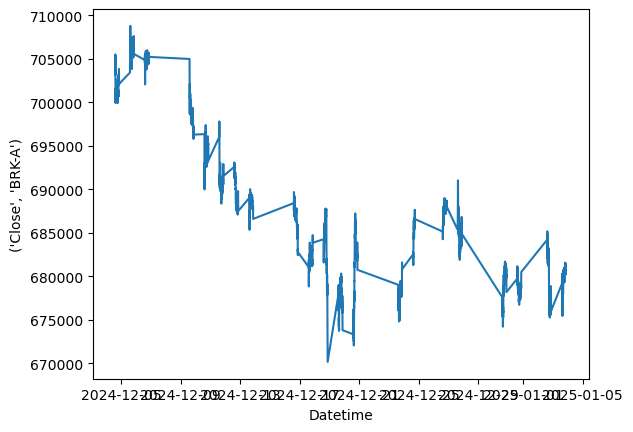

In [419]:
# plotting the closing price of each stock against time
scaler = MinMaxScaler(feature_range=(0,1))
fig, ax = plt.subplots()
inner_column = BRK_A_short_data.columns[0][1]
sns.lineplot(x=BRK_A_short_data.index, y=BRK_A_short_data[("Close", inner_column)],ax=ax)
plt.show()

In [404]:
inner_column = BRK_A_short_data.columns[0]
inner_column

('Close', 'BRK-A')

bivariate "XLF"